<a href="https://colab.research.google.com/github/RootCyberjet/Awesome-Red-Teaming/blob/master/StyleGAN2_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StyleGAN2 Demo 

**GANs** can be taught to generate realistic data (indistinguishable from authentic) such as images. Style Generative Adversarial Network (**StyleGAN**), is an extension to the basic GAN architecture, hover with the ability to control over the disentangled style properties of the generated images. StyleGANs sometimes generates artifacts. **StyleGAN2** got these artifacts exposed and analyzed leading to better generation via  applying changes in both model architecture and training methods.

For better understanding of the capabilities of StyleGAN and StyleGAN2 and how they work, we are going to use use them to **generate images** (with code), in different scenarios. 

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

**StyleGAN2** — [Official TensorFlow Implementation](https://github.com/NVlabs/stylegan2)

![alt text](https://github.com/NVlabs/stylegan2/raw/master/docs/stylegan2-teaser-1024x256.png)



In [0]:
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
!git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU: {}'.format(tf.test.gpu_device_name()))

Cloning into 'stylegan2'...
remote: Enumerating objects: 88, done.
remote: Total 88 (delta 0), reused 0 (delta 0), pack-reused 88
Unpacking objects: 100% (88/88), done.
/content/stylegan2
CPU says hello.
GPU says hello.
Tensorflow version: 1.15.0
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-07a6a982-a2cf-a7b3-ccd3-bbad3da0ff68)
GPU: /device:GPU:0


In [0]:
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import sys
import numpy as np
from PIL import Image, ImageDraw
import imageio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [0]:
import pretrained_networks
import run_generator
import run_projector

## Task 1: Generate random images

Use the Generator to generate faces starting from random points in the latent space.  

In [0]:
# generate random seeds
seeds = np.random.randint(1000000, size=9)

In [0]:
# load a pretrained model 

# 1024×1024 faces: stylegan2-ffhq-config-f.pkl
# 512×384 cars: stylegan2-car-config-f.pkl
# 256x256 horses: stylegan2-horse-config-f.pkl
# 256x256 churches: stylegan2-church-config-f.pkl
# 256x256 cats: stylegan2-cat-config-f.pkl

network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"
truncation_psi = 0.5

In [0]:
# This code is taken from: stylegan2/run_generator.py def generate_images(network_pkl, seeds, truncation_psi)

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
if truncation_psi is not None:
    Gs_kwargs.truncation_psi = truncation_psi


Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [0]:
results = []

for seed_idx, seed in enumerate(seeds):
    print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)-1))
    rnd = np.random.RandomState(seed)
    z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
    images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
    img = PIL.Image.fromarray(images[0], 'RGB')
    results.append(img)

Generating image for seed 463721 (0/8) ...
Generating image for seed 184939 (1/8) ...
Generating image for seed 594209 (2/8) ...
Generating image for seed 561782 (3/8) ...
Generating image for seed 145006 (4/8) ...
Generating image for seed 632631 (5/8) ...
Generating image for seed 368073 (6/8) ...
Generating image for seed 89131 (7/8) ...
Generating image for seed 190131 (8/8) ...


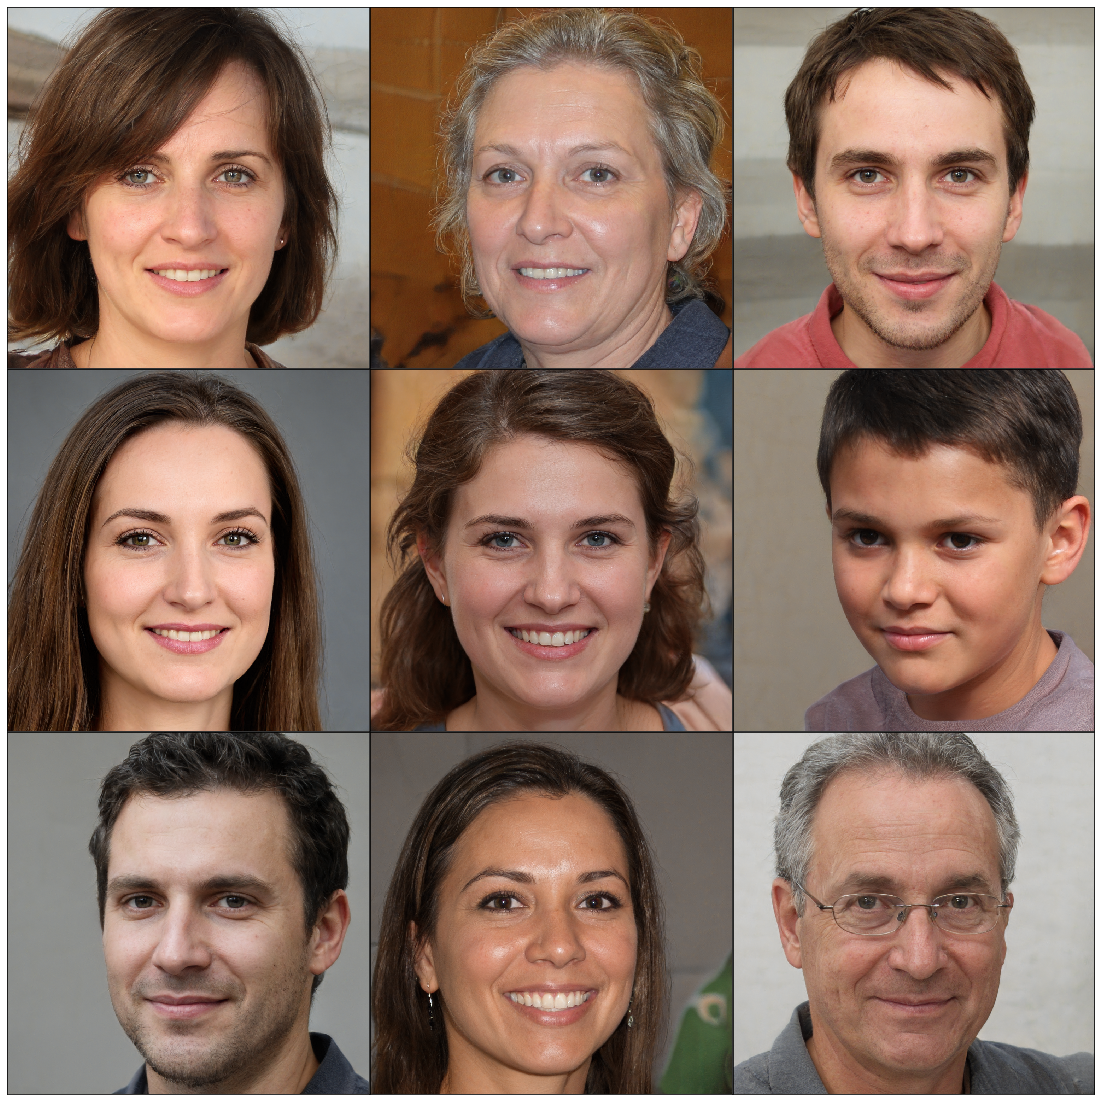

In [0]:
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3))

for ax, im in zip(grid, results):
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    ax.imshow(im)

## Task 2: Style Mixing

Having two images (and the corresponding w vectors), we can these w vectors together and get a new images with mixed style.  

In [0]:
import random 

# row_seeds = [random.randint(50,5000) for i in range(5)]
# col_seeds = [random.randint(50,5000) for i in range(4)]

row_seeds = [85,100,75,458,1500]
col_seeds= [55,821,1789,293] 
truncation_psi=1.0
col_styles = 4 # Style layer range '0-6'
minibatch_size = 4

In [0]:
# code from def style_mixing_example(network_pkl, row_seeds, col_seeds, truncation_psi, col_styles, minibatch_size=4):

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
w_avg = Gs.get_var('dlatent_avg') # [component]

Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = minibatch_size

print('Generating W vectors...')
all_seeds = list(set(row_seeds + col_seeds))
all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds]) # [minibatch, component]
all_w = Gs.components.mapping.run(all_z, None) # [minibatch, layer, component]
all_w = w_avg + (all_w - w_avg) * truncation_psi # [minibatch, layer, component]
w_dict = {seed: w for seed, w in zip(all_seeds, list(all_w))} # [layer, component]

print('Generating images...')
all_images = Gs.components.synthesis.run(all_w, **Gs_syn_kwargs) # [minibatch, height, width, channel]
image_dict = {(seed, seed): image for seed, image in zip(all_seeds, list(all_images))}

print('Generating style-mixed images...')
for row_seed in row_seeds:
    for col_seed in col_seeds:
        w = w_dict[row_seed].copy()
        w[col_styles] = w_dict[col_seed][col_styles]
        image = Gs.components.synthesis.run(w[np.newaxis], **Gs_syn_kwargs)[0]
        image_dict[(row_seed, col_seed)] = image

print('Generating image grid...')
_N, _C, H, W = Gs.output_shape
canvas = PIL.Image.new('RGB', (W * (len(col_seeds) + 1), H * (len(row_seeds) + 1)), 'black')
for row_idx, row_seed in enumerate([None] + row_seeds):
    for col_idx, col_seed in enumerate([None] + col_seeds):
        if row_seed is None and col_seed is None:
            continue
        key = (row_seed, col_seed)
        if row_seed is None:
            key = (col_seed, col_seed)
        if col_seed is None:
            key = (row_seed, row_seed)
        canvas.paste(PIL.Image.fromarray(image_dict[key], 'RGB'), (W * col_idx, H * row_idx))

print("done")

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Generating W vectors...
Generating images...
Generating style-mixed images...
Generating image grid...
done


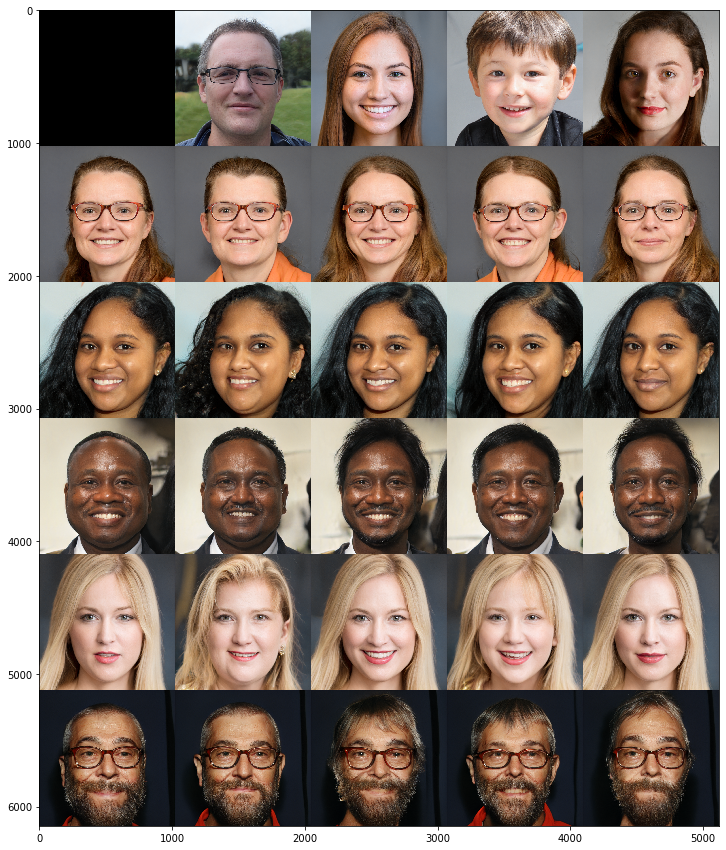

In [0]:
fig = plt.figure(figsize=(15., 15.))
plt.imshow(canvas)

## Task 3: Interpolation

Having two images (and the corresponding latent vectors), we can move from one image to the other by interpolating the latent vector.

In [0]:
def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

def interpolate(ls, steps):
   out = []
   for index in range(steps):
    fraction = index/float(steps) 
    out.append(ls[1]*fraction + ls[0]*(1-fraction))
   return out

In [0]:
zs = generate_zs_from_seeds([5017289 , 9148088])
number_of_steps = 15
zs_interpolated  = interpolate([zs[0],zs[1]],number_of_steps)

In [0]:
results = []

for z_idx, z_i in enumerate(zs_interpolated):
    print('Generating image for z_i (%d/%d) ...' % (z_idx, len(zs_interpolated)-1))
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
    images = Gs.run(z_i, None, **Gs_kwargs) # [minibatch, height, width, channel]
    img = PIL.Image.fromarray(images[0], 'RGB')
    results.append(img)

Generating image for z_i (0/14) ...
Generating image for z_i (1/14) ...
Generating image for z_i (2/14) ...
Generating image for z_i (3/14) ...
Generating image for z_i (4/14) ...
Generating image for z_i (5/14) ...
Generating image for z_i (6/14) ...
Generating image for z_i (7/14) ...
Generating image for z_i (8/14) ...
Generating image for z_i (9/14) ...
Generating image for z_i (10/14) ...
Generating image for z_i (11/14) ...
Generating image for z_i (12/14) ...
Generating image for z_i (13/14) ...
Generating image for z_i (14/14) ...


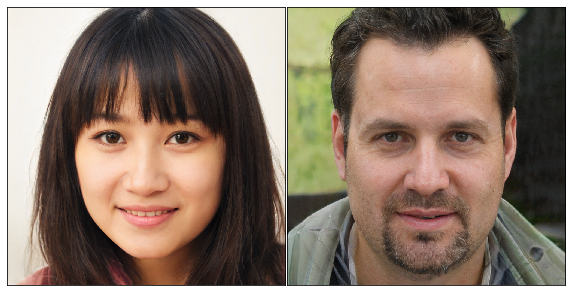

In [0]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2))

grid[0].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
grid[0].imshow(results[0])

grid[-1].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
grid[-1].imshow(results[-1])

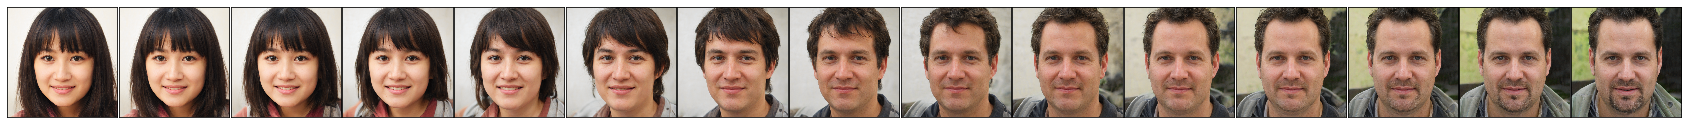

In [0]:
fig = plt.figure(figsize=(30., 20.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, number_of_steps))

for ax, im in zip(grid, results):
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    ax.imshow(im)

## Task 4: Projecting an input image to the latent space

Given an arbitrary input image, we can search for the best latent vector that generates this image. It is an optimization process where the network params are fixed, and the latent vector is optimized in the direction to minimized the feature based distance between the input image and the generated one. 

In [0]:
!mkdir projection
!mkdir projection/inputimg
!mkdir projection/out

# Upload an input image to 'stylegan2/projection/inputimg' PNG 1024x1024.
# for example: /stylegan2/projection/inputimg/001.png 

In [0]:
# Convert uploaded images to TFRecords
import dataset_tool
dataset_tool.create_from_images("./projection/records/", "./projection/inputimg/", True)

# Run the projector
import run_projector
import projector
import training.dataset
import training.misc
import os 

dataset_name = "records"
data_dir = "./projection"
num_images = 1 
num_snapshots = 100

proj = projector.Projector()
proj.num_steps = 400
proj.set_network(Gs)

print('Loading image from "%s"...' % dataset_name)
dataset_obj = training.dataset.load_dataset(data_dir=data_dir, tfrecord_dir=dataset_name, max_label_size=0, verbose=True, repeat=False, shuffle_mb=0)
assert dataset_obj.shape == Gs.output_shape[1:]

for image_idx in range(num_images):
    print('Projecting image %d/%d ...' % (image_idx, num_images))
    images, _labels = dataset_obj.get_minibatch_np(1)
    images = training.misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
    run_projector.project_image(proj, targets=images, png_prefix=dnnlib.make_run_dir_path('projection/out/image%04d-' % image_idx), num_snapshots=num_snapshots)

print("Done")

Loading images from "./projection/inputimg/"
Creating dataset "./projection/records/"
Added 1 images.
Loading image from "records"...
Streaming data using training.dataset.TFRecordDataset...
Dataset shape = [3, 1024, 1024]
Dynamic range = [0, 255]
Label size    = 0
Projecting image 0/1 ...
70 / 400 ... 

In [0]:
# Create video 

import glob

imgs = sorted(glob.glob("projection/out/*step*.png"))

target_imgs = sorted(glob.glob("projection/out/*target*.png"))
target_img = imageio.imread(target_imgs[0])

movieName = "projection/movie.mp4"
with imageio.get_writer(movieName, mode='I') as writer:
    for filename in imgs:
        image = imageio.imread(filename)
        # Concatenate images
        w,h = image.shape[0:2]
        canvas = PIL.Image.new('RGBA', (w*2,h), 'white')
        canvas.paste(Image.fromarray(target_img), (0, 0))
        canvas.paste(Image.fromarray(image), (w, 0))
        writer.append_data(np.array(canvas)) 


# Download the video from /stylegan2/projection/movie.mp4

In [0]:
!rm projection/out/*.*
!rm projection/records/*.*
# !rm projection/inputimg/*.*